# Tabular Playground Series 7 - Predict Air Pollution

The dataset deals with predicting air pollution in a city via various input sensor values. The task is to predict, based on the sensor, values **three** target variables: target_carbon_monoxide,target_benzene and target_nitrogen_oxides. Submissions are evaluated using the [mean column-wise root mean squared logarithmic error](http://www.kaggle.com/c/tabular-playground-series-jul-2021/overview/evaluation).

The model is created based on my [EDA](https://www.kaggle.com/melanie7744/tps7-interactive-eda-with-plotly/edit).

Steps:
* feature engineering
* model tuning with Optuna
* visual checks on model performance
* predict & submit

At the end of the notebook there is a section about understanding the error metric.

Feedback is highly appreciated!


### I decided not to use the leak!


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sklearn
print("scikit-learn version: {}". format(sklearn.__version__))
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import plotly
import plotly.express as px
import plotly.graph_objects as go
print("plotly version: {}". format(plotly.__version__))


import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
print("xgboost version: {}". format(xgb.__version__))

import optuna

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

scikit-learn version: 0.23.2
matplotlib version: 3.4.2
plotly version: 5.1.0
xgboost version: 1.4.2
/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


In [2]:
# read input files
df_train = pd.read_csv("../input/tabular-playground-series-jul-2021/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-jul-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-jul-2021/sample_submission.csv")
target_cols = ["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]
df_test = df_test.loc[1:] # remove the row that is duplicated in train and test, messes up lag, pct features. Is added again later.
df_all = df_train.drop(columns=target_cols).append(df_test) # makes preprocessing easier

In [3]:
# store target columns
y_cm = df_train["target_carbon_monoxide"]
y_b = df_train["target_benzene"]
y_no = df_train["target_nitrogen_oxides"]
# store known target values
known_target = df_train.iloc[7110][target_cols]

## Adding features

In [4]:

# consider daily sums here or 6h sums

# lags features
df_all = df_train.drop(columns=target_cols).append(df_test)
lag_columns = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'] # define which for which columns shifts/lags shall be created
shift_range = [3,6,9,12] # define lag range

# create lags
for column in lag_columns:
    for i in shift_range:
        col_name = (column +"_lag_" + str(i))
        df_all[col_name] = df_all[column].shift(periods = i)
    
#df_all.head(10)


In [5]:
# percentage change features, calculate change compared to previous hour, removed for now, did not improve result
#pct_columns = lag_columns
#for column in lag_columns:
#    col_name = column + "_pct"
#    df_all[col_name] = df_all[column].pct_change()*100
#df_all.head()

In [6]:
df_all['date_time'] = pd.to_datetime(df_all['date_time'])
df_all['year'] = df_all['date_time'].dt.year
df_all['month'] = df_all['date_time'].dt.month
df_all['day'] = df_all['date_time'].dt.day
df_all['hour'] = df_all['date_time'].dt.hour
df_all['dayofweek'] = df_all['date_time'].dt.dayofweek
df_all['weekend'] = df_all['dayofweek'].apply(lambda x: 1 if (x>4)  else 0) # Sat, Sun are counted as weekend
df_all['rushhour'] = df_all['hour'].apply(lambda x: 1 if x in [8,9,18,19,20]  else 0) # define those hour as rush hour
df_all['time'] = df_all['date_time'].astype(np.int64)//10**9 # Unix time
#df_all.head()

In [7]:
# check the rows where the test set starts 
df_all.iloc[7109:7113]

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_1_lag_3,...,sensor_5_lag_9,sensor_5_lag_12,year,month,day,hour,dayofweek,weekend,rushhour,time
7109,2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1000.5,...,679.8,700.3,2010,12,31,23,4,0,0,1293836400
7110,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1022.7,...,597.9,571.3,2011,1,1,0,5,1,0,1293840000
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,1044.4,...,769.6,689.9,2011,1,1,1,5,1,0,1293843600
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,952.8,...,913.9,679.8,2011,1,1,2,5,1,0,1293847200


In [8]:
# split again in train and test
df_train =  df_all.iloc[0:df_train.shape[0]]
df_test = df_all.iloc[df_train.shape[0]-1:]
# remove rows containing Nan due to the lags
df_train = df_train.loc[max(shift_range):]
y_no = y_no.loc[max(shift_range):]
y_cm = y_cm.loc[max(shift_range):]
y_b = y_b.loc[max(shift_range):]
#df_test.head()

## Tune Model
(Changed in Version 16.) Use 3 models to predict the 3 target variables. Use Optuna to tune the models. (No chained prediction for the moment any more.) Use k-fold cross validation. This is just a guess, seasonality captured in the features could be enough. And we don't have enough training data to make good use of seasonality.

**Step 1**: Setup Optuna Tuner

In [9]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=7)

In [10]:
def tune(objective):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100) 

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [11]:
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 1000) 
    _max_depth = trial.suggest_int("max_depth", 2, 10) 
    _learning_rate = trial.suggest_float("learning_rate", 1e-6, 0.3, log=True)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    _subsample = trial.suggest_float('subsample', 0.5, 1)
    _colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10, log=True)

    
    model = xgb.XGBRegressor(
        objective = 'reg:squarederror', #'reg:sqarederror' is default and gives better rsmle than 'reg:squaredlogerror'. why?
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_lambda=_reg_lambda,
        random_state=7,
    )
    

    val_rmsle = []
    for train_index, test_index in kfolds.split(X):
 
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmsle", 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            verbose=False, 
            early_stopping_rounds = 50)
    
        val_rmsle.append(model.evals_result()['validation_1']['rmsle'][-1])
    
   
    score = sum(val_rmsle)/len(val_rmsle)
    
    return score


**Step 2:** Find hyperparameters for all three target variables seperately.

In [12]:
X = df_train.drop(columns="date_time")
y = y_b
#xgb_params_y_b = tune(xgb_objective) # uncomment to run optuna tuning again, takes time....

# Optuna Result: Best score: 0.0863592 
xgb_params_y_b = {'n_estimators': 365,
 'max_depth': 10,
 'learning_rate': 0.02965812395223671,
 'gamma': 0.3086304942573926,
 'min_child_weight': 9.03951830237063,
 'subsample': 0.5054451890047076,
 'colsample_bytree': 0.9986600565238701,
 'reg_lambda': 1.5966168376624417}

In [13]:
X = df_train.drop(columns="date_time")
y = y_cm
#xgb_params_y_cm = tune(xgb_objective) # uncomment to run optuna tuning again, takes time....

# Optuna Result: Best score: 0.09788859999999999 
xgb_params_y_cm = {'n_estimators': 418,
 'max_depth': 5,
 'learning_rate': 0.07432650387394699,
 'gamma': 0.0676479407897746,
 'min_child_weight': 1.3220415658077735,
 'subsample': 0.8146019010378812,
 'colsample_bytree': 0.8918164888978178,
 'reg_lambda': 5.394004764094763}

In [14]:
X = df_train.drop(columns="date_time")
y = y_no
#xgb_params_y_no = tune(xgb_objective) # uncomment to run optuna tuning again, takes time....

#[W 2021-07-16 12:08:03,325] Trial 0 failed, because the objective function returned nan. --- todo: check what went wrong
# Optuna Result: Best score: 0.20224699999999998 
xgb_params_y_no = {'n_estimators': 434,
 'max_depth': 10,
 'learning_rate': 0.042338664081773426,
 'gamma': 0.43939165464469737,
 'min_child_weight': 2.6282895129902637,
 'subsample': 0.835280405845509,
 'colsample_bytree': 0.8120530400759991,
 'reg_lambda': 5.228573656907881}

## Visualize Model Performance with Validation Set

In [15]:
# use all except 2 month as training set
# use the last 2 month weeks as validation set (methodisch nicht ganz sauber da diese Daten benutzt wurden um die Hyperparamter zu lernen, potential leakage)
X_train = df_train[(df_train.year == 2010) & (df_train.month.isin(np.arange(3, 11, 1)))].drop(columns="date_time")
len_train = X_train.shape[0] + max(shift_range) -1
y_train_no = y_no.loc[:len_train]
y_train_cm = y_cm.loc[:len_train]
y_train_b = y_b.loc[:len_train]

X_val = df_train.iloc[X_train.shape[0]:]
val_time = X_val.date_time
X_val = X_val.drop(columns="date_time")
y_val_no = y_no.loc[len_train+1:]
y_val_cm = y_cm.loc[len_train+1:]
y_val_b = y_b.loc[len_train+1:]

In [16]:
# target_benzene
model = XGBRegressor(
    objective = 'reg:squarederror', # 'reg:squaredlogerror' gives worse rsmle results, is not able to fit to the peaks, change and recalculate viz to see that
    ** xgb_params_y_b,
    seed=7)

model.fit(
            X_train, 
            y_train_b, 
            eval_metric="rmsle", 
            eval_set=[(X_train, y_train_b), (X_val, y_val_b)], 
            verbose=10, 
            early_stopping_rounds = 10)
predictions_y_b = model.predict(X_val)

#[158]	validation_0-rmsle:0.05487	validation_1-rmsle:0.09711

[0]	validation_0-rmsle:1.73022	validation_1-rmsle:1.71264
[10]	validation_0-rmsle:0.90280	validation_1-rmsle:0.88765
[20]	validation_0-rmsle:0.57785	validation_1-rmsle:0.56963
[30]	validation_0-rmsle:0.39671	validation_1-rmsle:0.39396
[40]	validation_0-rmsle:0.28429	validation_1-rmsle:0.28727
[50]	validation_0-rmsle:0.21096	validation_1-rmsle:0.21912
[60]	validation_0-rmsle:0.16159	validation_1-rmsle:0.17262
[70]	validation_0-rmsle:0.12815	validation_1-rmsle:0.14248
[80]	validation_0-rmsle:0.10504	validation_1-rmsle:0.12239
[90]	validation_0-rmsle:0.08899	validation_1-rmsle:0.11008
[100]	validation_0-rmsle:0.07785	validation_1-rmsle:0.10314
[110]	validation_0-rmsle:0.07007	validation_1-rmsle:0.09933
[120]	validation_0-rmsle:0.06474	validation_1-rmsle:0.09792
[130]	validation_0-rmsle:0.06082	validation_1-rmsle:0.09715
[140]	validation_0-rmsle:0.05805	validation_1-rmsle:0.09677
[150]	validation_0-rmsle:0.05597	validation_1-rmsle:0.09666
[159]	validation_0-rmsle:0.05466	validation_1-rmsle

In [17]:
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=val_time, 
                 y=y_val_b, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 name="Benzene Ground Truth")
)
fig.add_trace(
      go.Scatter(x=val_time, 
                 y=predictions_y_b, 
                 mode = 'lines', 
                 line = {'color':'black', 'width' : 1},
                 name="Benzene Predicted")
)

fig.update_layout(
    title="Benzene Predicted (val data = last 2 month) vs. Ground Truth (train data)"
)
fig.show()

In [18]:
# target_carbon_monoxides
model = XGBRegressor(
    objective = 'reg:squarederror', 
    ** xgb_params_y_cm,
    seed=7)

model.fit(
            X_train, 
            y_train_cm, 
            eval_metric="rmsle", 
            eval_set=[(X_train, y_train_cm), (X_val, y_val_cm)], 
            verbose=10, 
            early_stopping_rounds = 10)
predictions_y_cm = model.predict(X_val)

#[148]	validation_0-rmsle:0.06803	validation_1-rmsle:0.22248

[0]	validation_0-rmsle:0.63656	validation_1-rmsle:0.81103
[10]	validation_0-rmsle:0.25445	validation_1-rmsle:0.43503
[20]	validation_0-rmsle:0.14160	validation_1-rmsle:0.32336
[30]	validation_0-rmsle:0.10458	validation_1-rmsle:0.27732
[40]	validation_0-rmsle:0.09213	validation_1-rmsle:0.25727
[50]	validation_0-rmsle:0.08568	validation_1-rmsle:0.24341
[60]	validation_0-rmsle:0.08222	validation_1-rmsle:0.23726
[70]	validation_0-rmsle:0.07997	validation_1-rmsle:0.23248
[80]	validation_0-rmsle:0.07842	validation_1-rmsle:0.22985
[90]	validation_0-rmsle:0.07638	validation_1-rmsle:0.22757
[100]	validation_0-rmsle:0.07466	validation_1-rmsle:0.22502
[110]	validation_0-rmsle:0.07324	validation_1-rmsle:0.22420
[120]	validation_0-rmsle:0.07170	validation_1-rmsle:0.22371
[130]	validation_0-rmsle:0.07043	validation_1-rmsle:0.22329
[140]	validation_0-rmsle:0.06899	validation_1-rmsle:0.22252
[149]	validation_0-rmsle:0.06793	validation_1-rmsle:0.22236


In [19]:
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=val_time, 
                 y=y_val_cm, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 name="Carbon Monoxide Ground Truth")
)
fig.add_trace(
      go.Scatter(x=val_time, 
                 y=predictions_y_cm, 
                 mode = 'lines', 
                 line = {'color':'black', 'width' : 1},
                 name="Carbon Monoxide Predicted")
)

fig.update_layout(
    title="Carbon Monoxide Predicted (val data = last 2 month) vs. Ground Truth (train data)"
)
fig.show()

In [20]:
# target nitrogen_oxides
model = XGBRegressor(
    objective = 'reg:squarederror', # 'reg:squaredlogerror' gives worse rsmle results, is not able to fit to the data, change and recalculate viz to see that
    ** xgb_params_y_no,
    seed=7)

model.fit(
            X_train, 
            y_train_no, 
            eval_metric="rmsle", 
            eval_set=[(X_train, y_train_no), (X_val, y_val_no)], 
            verbose=30, 
            early_stopping_rounds = 10)
predictions_y_no = model.predict(X_val)

#[433]	validation_0-rmsle:0.04537	validation_1-rmsle:0.54051

[0]	validation_0-rmsle:2.86758	validation_1-rmsle:3.55352
[30]	validation_0-rmsle:0.34105	validation_1-rmsle:0.88152
[60]	validation_0-rmsle:0.15296	validation_1-rmsle:0.67246
[90]	validation_0-rmsle:0.11353	validation_1-rmsle:0.60913
[120]	validation_0-rmsle:0.10109	validation_1-rmsle:0.58455
[150]	validation_0-rmsle:0.09405	validation_1-rmsle:0.56849
[180]	validation_0-rmsle:0.08874	validation_1-rmsle:0.56009
[210]	validation_0-rmsle:0.08445	validation_1-rmsle:0.55309
[240]	validation_0-rmsle:0.07854	validation_1-rmsle:0.55054
[270]	validation_0-rmsle:0.07313	validation_1-rmsle:0.54769
[300]	validation_0-rmsle:0.06814	validation_1-rmsle:0.54609
[330]	validation_0-rmsle:0.06258	validation_1-rmsle:0.54380
[360]	validation_0-rmsle:0.05734	validation_1-rmsle:0.54272
[390]	validation_0-rmsle:0.05249	validation_1-rmsle:0.54154
[420]	validation_0-rmsle:0.04748	validation_1-rmsle:0.54078
[433]	validation_0-rmsle:0.04537	validation_1-rmsle:0.54050


In [21]:
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=val_time, 
                 y=y_val_no, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 name="Nitrogen Oxides Ground Truth")
)
fig.add_trace(
      go.Scatter(x=val_time, 
                 y=predictions_y_no, 
                 mode = 'lines', 
                 line = {'color':'black', 'width' : 1},
                 name="Nitrogen Oxides Predicted")
)

fig.update_layout(
    title="Nitrogen Oxides Predicted (val data = last 2 month) vs. Ground Truth (train data)"
)
fig.show()

As already indicated by the RMSLE, the predictions for Nitrogen Oxides are worse than for the other 2 variables. The model is not able to capture the peeks well. It can be seen that in the timeframe from Dec 14th - Dec 17th where the sensor behave strange (see [EDA](https://www.kaggle.com/melanie7744/tps7-interactive-eda-with-plotly/edit) ), the predictions are worst. 

## Predict

Predictions are made for all three target variables seperately. Feature importance as seen by XGBoost is visualized.

In [22]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [23]:
X_test = df_test.drop(columns="date_time")

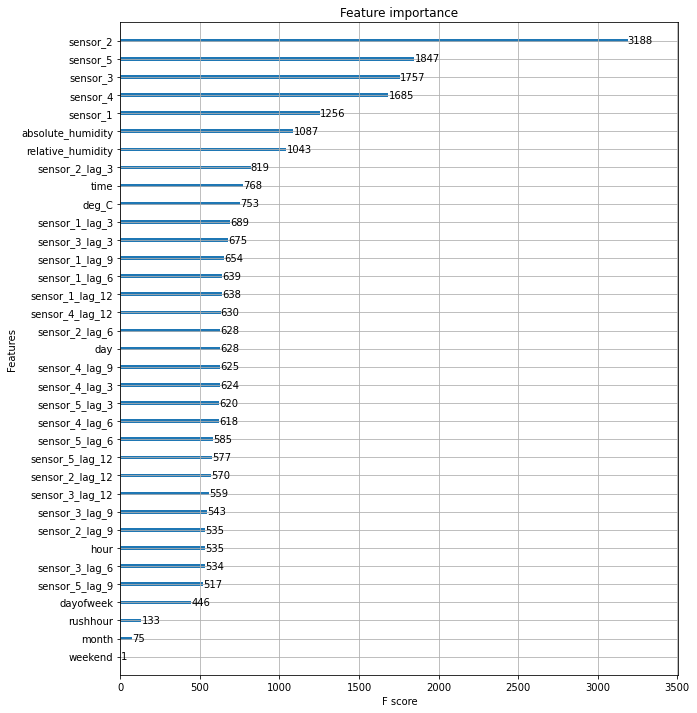

In [24]:
# target_benzene
X = df_train.drop(columns="date_time")
y = y_b

xgb_params_y_b = {'n_estimators': 365,
 'max_depth': 10,
 'learning_rate': 0.02965812395223671,
 'gamma': 0.3086304942573926,
 'min_child_weight': 9.03951830237063,
 'subsample': 0.5054451890047076,
 'colsample_bytree': 0.9986600565238701,
 'reg_lambda': 1.5966168376624417}

model = XGBRegressor(
    objective = 'reg:squarederror', # 'reg:squaredlogerror' gives worse rsmle results
    ** xgb_params_y_b,
    seed=7)

model.fit(X,y)
predictions_y_b = model.predict(X_test)

plot_features(model,(10,12) )
plt.show()

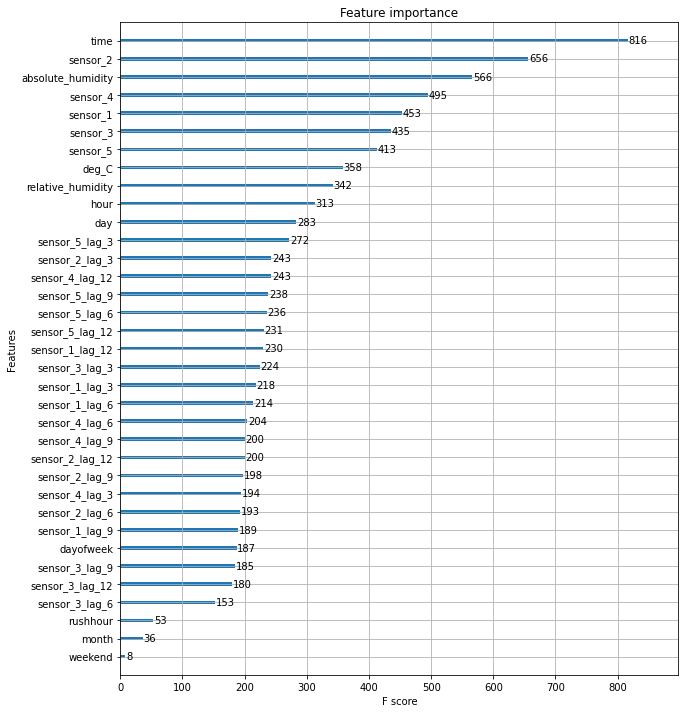

In [25]:
# target_carbon_monoxide
X = df_train.drop(columns="date_time")
y = y_cm

xgb_params_y_cm = {'n_estimators': 418,
 'max_depth': 5,
 'learning_rate': 0.07432650387394699,
 'gamma': 0.0676479407897746,
 'min_child_weight': 1.3220415658077735,
 'subsample': 0.8146019010378812,
 'colsample_bytree': 0.8918164888978178,
 'reg_lambda': 5.394004764094763}

model = XGBRegressor(
    objective = 'reg:squarederror',
    ** xgb_params_y_cm,
    seed=7)

model.fit(X,y)
predictions_y_cm = model.predict(X_test)

plot_features(model,(10,12) )
plt.show()

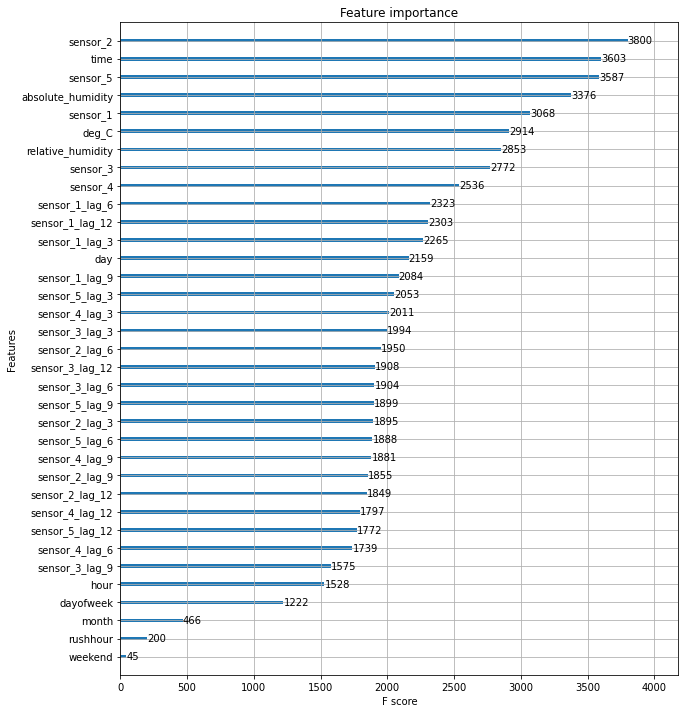

In [26]:
# target_nitrogen_oxides
X = df_train.drop(columns="date_time")
y = y_no

xgb_params_y_no = {'n_estimators': 434,
 'max_depth': 10,
 'learning_rate': 0.042338664081773426,
 'gamma': 0.43939165464469737,
 'min_child_weight': 2.6282895129902637,
 'subsample': 0.835280405845509,
 'colsample_bytree': 0.8120530400759991,
 'reg_lambda': 5.228573656907881}

model = XGBRegressor(
    objective = 'reg:squarederror', 
    ** xgb_params_y_no,
    seed=7)

model.fit(X,y)
predictions_y_no = model.predict(X_test)

plot_features(model,(10,12) )
plt.show()

## Submission

In [27]:
# generate submission file (Public Score 0.20824)
submission_xgb = pd.DataFrame(data={"date_time" : sample_submission.date_time,
                               "target_carbon_monoxide" : predictions_y_cm,
                               "target_benzene" : predictions_y_b,
                               "target_nitrogen_oxides" : predictions_y_no})
submission_xgb.loc[0,target_cols] = known_target # replace the first row with the known values as timestamp is identical
submission_xgb.to_csv('submission_xgb.csv', index=False)
submission_xgb.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.400000,4.100000,186.500000
1,2011-01-01 01:00:00,2.168112,8.030599,313.224640
2,2011-01-01 02:00:00,1.869296,7.467501,244.013107
3,2011-01-01 03:00:00,1.941784,8.185823,260.698761
4,2011-01-01 04:00:00,1.329386,6.029226,197.402985


I generate multiple submission files using a factor to uplift my predictions. This idea is based on the graphic analysis using the validation set (predictions were often below ground truth) and the fact that RMSLE penalizes underpredictions harder than overpredictions.

After some unsucessfull trials with too strong factors, I found factors that actually improved my Public Score!

In [28]:
# generate submission file #  very low factors (Public Score: 0.20777, improvement!)
submission_xgb = pd.DataFrame(data={"date_time" : sample_submission.date_time,
                               "target_carbon_monoxide" : predictions_y_cm*1.001,
                               "target_benzene" : predictions_y_b*1.001,
                               "target_nitrogen_oxides" : predictions_y_no*1.01})
submission_xgb.loc[0,target_cols] = known_target # replace the first row with the known values as timestamp is identical
submission_xgb.to_csv('submission_xgb_verylowfactors.csv', index=False)
submission_xgb.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.400000,4.100000,186.500000
1,2011-01-01 01:00:00,2.170280,8.038630,316.356873
2,2011-01-01 02:00:00,1.871166,7.474968,246.453232
3,2011-01-01 03:00:00,1.943726,8.194010,263.305756
4,2011-01-01 04:00:00,1.330715,6.035255,199.377014


In [29]:
# generate submission file # low factors (gives Public score of 0.21209)
submission_xgb = pd.DataFrame(data={"date_time" : sample_submission.date_time,
                               "target_carbon_monoxide" : predictions_y_cm*1.05,
                               "target_benzene" : predictions_y_b*1.01,
                               "target_nitrogen_oxides" : predictions_y_no*1.1})
submission_xgb.loc[0,target_cols] = known_target # replace the first row with the known values as timestamp is identical
submission_xgb.to_csv('submission_xgb_low_factor.csv', index=False)
submission_xgb.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.400000,4.100000,186.500000
1,2011-01-01 01:00:00,2.276518,8.110905,344.547119
2,2011-01-01 02:00:00,1.962761,7.542176,268.414429
3,2011-01-01 03:00:00,2.038873,8.267681,286.768646
4,2011-01-01 04:00:00,1.395855,6.089518,217.143295


In [30]:
# generate submission file # min factors (gives Public score of 0.20802)
submission_xgb = pd.DataFrame(data={"date_time" : sample_submission.date_time,
                               "target_carbon_monoxide" : predictions_y_cm*1.0007,
                               "target_benzene" : predictions_y_b*1.0007,
                               "target_nitrogen_oxides" : predictions_y_no*1.005})
submission_xgb.loc[0,target_cols] = known_target # replace the first row with the known values as timestamp is identical
submission_xgb.to_csv('submission_xgb_minfactor.csv', index=False)
submission_xgb.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.400000,4.100000,186.500000
1,2011-01-01 01:00:00,2.169630,8.036220,314.790771
2,2011-01-01 02:00:00,1.870605,7.472728,245.233170
3,2011-01-01 03:00:00,1.943143,8.191553,262.002258
4,2011-01-01 04:00:00,1.330316,6.033446,198.389999


In [31]:
# generate submission file # new factors 
submission_xgb = pd.DataFrame(data={"date_time" : sample_submission.date_time,
                               "target_carbon_monoxide" : predictions_y_cm*1.001,
                               "target_benzene" : predictions_y_b*1.001,
                               "target_nitrogen_oxides" : predictions_y_no*1.005})
submission_xgb.loc[0,target_cols] = known_target # replace the first row with the known values as timestamp is identical
submission_xgb.to_csv('submission_xgb_newfactor.csv', index=False)

In [32]:
# public score = 0.77258
sample_submission.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,2.0,10.0,300.0
1,2011-01-01 01:00:00,2.0,10.0,300.0
2,2011-01-01 02:00:00,2.0,10.0,300.0
3,2011-01-01 03:00:00,2.0,10.0,300.0
4,2011-01-01 04:00:00,2.0,10.0,300.0


## Understanding the error metric

In [33]:
p = 0.1
a = 0.2
((np.log(p+1) - np.log(a+1))**2)**0.5

0.08701137698962966

In [34]:
p = np.array(list(range(0,50,1)))/10 # predicted
a = np.array([1] * 50)            # actual
y=((np.log(p+1) - np.log(a+1))**2)**0.5 #rmsle
mse = (a-p)**2
rmse = ((a-p)**2)**0.5
#display(p)
#display(y)
#display(mse)
#display(rmse)

In [35]:
import matplotlib
import matplotlib.pyplot as plt

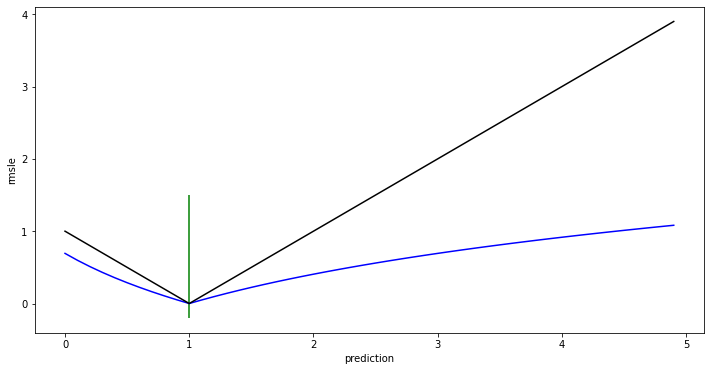

In [36]:
plt.figure(figsize = (12,6))
plt.plot(p,y, color = 'blue')
plt.vlines(1,-0.2,1.5, colors='green', label='actual value')
#plt.plot(p,mse, color = 'red')
plt.plot(p,rmse, color = 'black')
plt.xlabel("prediction")
plt.ylabel("rmsle")
plt.show()

Predictions lower than the ground truth are penalized harder than predictions above ground truth.

Compared to MSE and RMSE the RMSLE penalized predictions that are far off, less.

In [37]:
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import mean_squared_error

In [38]:
y_true = [3, 2, 4]
y_pred = 1.1 * np.array(y_true)
print("MSLE:  ", mean_squared_log_error(y_true, y_pred))
print("RMLSE: ", np.sqrt(mean_squared_log_error(y_true, y_pred)))
print("RMLSE: ", mean_squared_error(np.log1p(y_true), np.log1p(y_pred), squared = False))

MSLE:   0.005106166884898795
RMLSE:  0.07145744807155371
RMLSE:  0.07145744807155371


In [39]:
p = np.array(y_pred)
a = np.array(y_true)
y=((np.log(p+1) - np.log(a+1))**2)
sum(y) / len(y)
print("MSLE:  ", sum(y) / len(y))
print("RMLSE: ", (sum(y) / len(y))**0.5)

MSLE:   0.005106166884898808
RMLSE:  0.0714574480715538


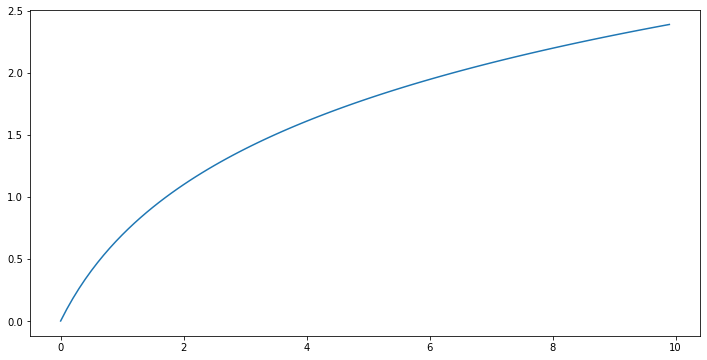

In [40]:
x = np.array(list(range(0,100)))/10
y = np.log(x+1)   # equivalent: y = np.log1p(x)

plt.figure(figsize = (12,6))
plt.plot(x,y)
plt.show()